# № 4 Эффективность сотрудников

**Формулировка гипотезы**

H₀: Средние продажи сотрудников не различаются.   
H₁: Существуют статистически значимые различия в эффективности сотрудников.  

**Тесты**  
- ANOVA (предпосылки не выполнены, тест не проводился)
    - Shapiro-Wilk
    - Kolmogorov-Smirnov
    - Bartlett's test 
    - Levene's test
- Kruskal–Wallis test
    - Пост-хок Dunn test (Bonferroni)
- Многофакторный дисперсионный анализ (ANOVA, тип II)

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
import scipy.stats as stats
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.graphics.gofplots import qqplot
from itertools import combinations
import statsmodels.api as sm
import statsmodels.formula.api as smf
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query_sales = 'SELECT * FROM sales'
data = db_connection.execute_query(query_sales)

query_employee  = 'SELECT * FROM employee'
employee = db_connection.execute_query(query_employee)

query_shops = 'SELECT * FROM shops'
shops = db_connection.execute_query(query_shops)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

### Формирование чеков

In [4]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,final_price
0,15,11,2491,2022-05-03,8706.0,0.0,15,8706.0
1,15,11,2497,2022-05-04,2677.0,0.0,18,2677.0
2,15,11,2499,2022-05-04,2150.0,0.0,18,2150.0
3,15,11,2501,2022-05-04,959.0,0.0,18,959.0
4,15,11,2503,2022-05-04,1194.0,0.0,18,1194.0


### EDA

**Статистика по группам**

In [5]:
grouped.groupby('dr_tabempl')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,dr_tabempl,mean,median,count
0,15,1590.38,1160.99,50
1,21,535.45,308.00,1186
2,22,789.43,424.00,876
3,25,659.50,363.00,1074
4,27,795.13,460.00,1103
5,29,599.19,354.00,1305
6,30,535.95,294.00,1865
7,36,586.55,387.00,1132
8,37,598.48,311.00,939
9,47,442.07,250.00,1885


**Визуализация распределений**

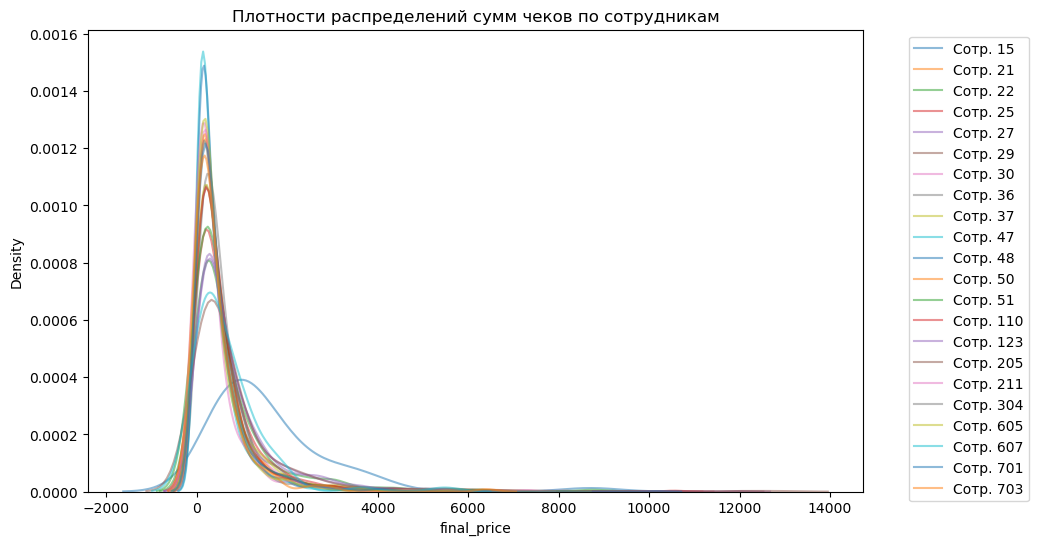

In [6]:
# Группировка по сотрудникам
groups = grouped.groupby('dr_tabempl')['final_price']

# 1. --Визуализация плотностей KDE
plt.figure(figsize=(10, 6))
for name, group in groups:
    sns.kdeplot(group, label=f"Сотр. {name}", alpha=0.5)
plt.title("Плотности распределений сумм чеков по сотрудникам")
plt.xlabel("final_price")
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='best')
plt.show()

- Все кривые имеют пик вблизи нуля – нескольких сотен рублей, следовательно большинство чеков у всех сотрудников в этой зоне.    
- Хвосты (справа) длинные, есть редкие большие чеки (до 14 000).  
- Форма у большинства сотрудников очень похожа: узкий высокий пик + длинный правый хвост.  
- Есть отклонения: например, «Сотр. 15» и «Сотр. 47» имеют кривые с меньшей высотой и более "размазанным" распределением, следовательно, у них структура чеков может отличаться.

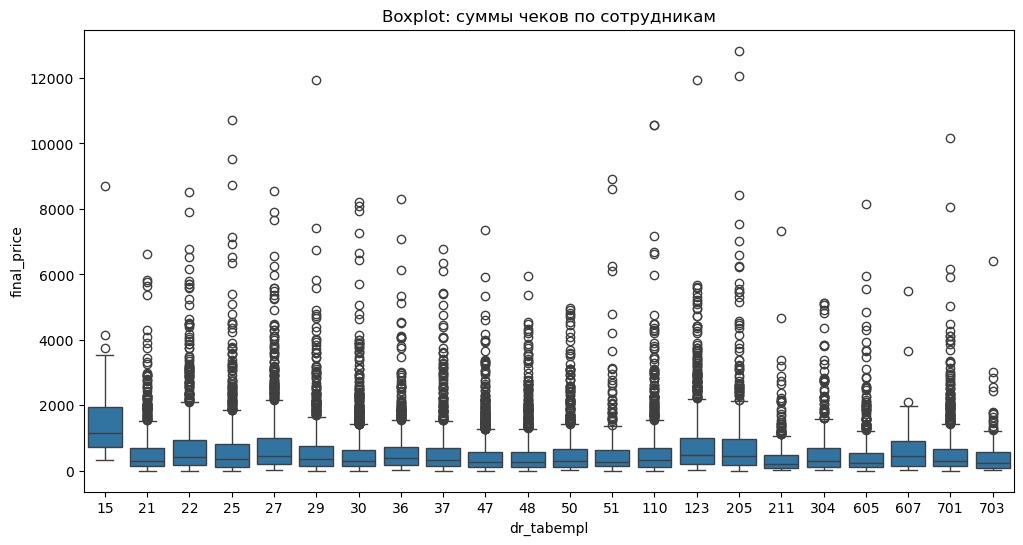

In [7]:
# 2. --Boxplot — сравнение распределений по медианам и разбросу
plt.figure(figsize=(12, 6))
sns.boxplot(x="dr_tabempl", y="final_price", data=grouped)
plt.title("Boxplot: суммы чеков по сотрудникам")
plt.show()

1. Большое количество выбросов (outliers):
- Практически у каждого сотрудника видно множество точек, выходящих за пределы "усов" (верхнего и нижнего квартилей).
- Это говорит о том, что у многих сотрудников есть разовые, но крупные продажи, значительно превышающие медианное значение.

2. Основная часть продаж — в нижнем диапазоне:
- Большинство "ящиков" (box) сосредоточено ниже отметки в 2000–2500 единиц по оси final_price, что говорит о небольших средних чеках.
- Верхняя граница межквартильного диапазона у большинства сотрудников — в районе 1000–2000.

3. Медианные значения (толстые линии в boxplot):
- У всех сотрудников медианные значения продаж примерно одинаковые, за исключением сотрудника 15, у которого они заметно выше.
- Это может указывать на более успешные или дорогие продажи у этого сотрудника.

4. Сотрудник 15 выделяется:
У него:
- Самая высокая медиана.
- Самый широкий межквартильный диапазон.
- Меньшее количество выбросов (относительно остальных), но сами значения выше.
Возможно, это топ-продавец, работающий с дорогими товарами или крупными клиентами.

5. Сотрудники 123, 205, 110, 607, 703 — разнообразие продаж:
- У них также наблюдается широкий разброс значений, т.е. как дешёвые, так и дорогие продажи.
- Вероятно, они работают в нишах с более широкой линейкой товаров или с разными типами клиентов.

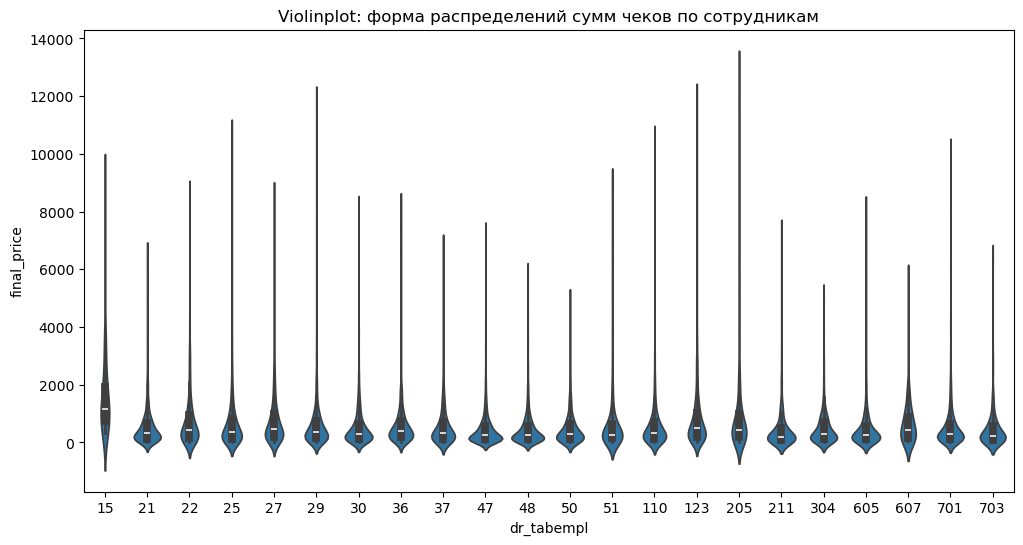

In [8]:
# 3. --Violinplot — форма распределения (сглаженная плотность)
plt.figure(figsize=(12, 6))
sns.violinplot(x="dr_tabempl", y="final_price", data=grouped)
plt.title("Violinplot: форма распределений сумм чеков по сотрудникам")
plt.show()

1. Сотрудник 15 снова выделяется:
У него:
- Медиана и интерквартильный диапазон выше, чем у всех остальных.
- Распределение имеет явное "тело" в верхней части — это значит, что он часто проводит продажи с высокими чеками.
- Распределение асимметрично, с более полным "телом" сверху — сильный сигнал о высокой средней стоимости чеков.

2. У остальных сотрудников:
- Распределения сильно сжаты в нижней части (ближе к нулю):
    - Основная масса продаж — в диапазоне до 1000 единиц.
    - Это говорит о преобладании мелких транзакций у большинства сотрудников.
- "Хвосты" в верхнюю сторону — почти у всех:
    - Эти хвосты представляют редкие, но крупные продажи.
    - Например, у сотрудников 205, 211 и 123 хвосты тянутся вплоть до 12000–14000, что говорит о возможности крупных сделок, хоть и нечастых.

3. Симметрия и пиковость:
- Почти все распределения асимметричны и имеют один острый пик в нижнем диапазоне.
- Это означает:
    - Большинство чеков низкие.
    - Случаи крупных чеков — редкость.
- Такая форма может указывать на типовой ассортимент товаров/услуг, с редкими исключениями (например, премиальные товары).

**Интерпретация результатов**  
1. Сотрудник 15 — лидер по качеству продаж:
- Часто работает с более дорогими чеками.
- Возможно, обслуживает премиум-клиентов или продаёт более дорогую продукцию.
- Возможно, его стратегия продаж эффективнее

2. Остальные сотрудники — массовый сегмент:
- Работа с типичными мелкими заказами.
- У большинства сотрудников типичное распределение продаж с небольшими средними чеками и редкими крупными сделками
- У всех есть доступ к крупным чекам, но они случаются редко.

3. Сильная положительная асимметрия:
- Для всех сотрудников: мало больших продаж, много маленьких.
- Полезно для прогнозирования — например, можно использовать лог-нормальное распределение для моделирования.

## ANOVA

### Проверка предпосылок

In [9]:
# ============================
# 1. Проверка предпосылок
# ============================

print("=== Проверка нормальности (Shapiro + KS) ===")
for day, group in grouped.groupby("dr_tabempl"):
    stat_shapiro, p_shapiro = stats.shapiro(group["final_price"])
    mean, std = group["final_price"].mean(), group["final_price"].std()
    stat_ks, p_ks = stats.kstest(group["final_price"], "norm", args=(mean, std))
 
    print(f"\nСотрудник: {day}")
    print(f"Shapiro-Wilk: stat={stat_shapiro:.4f}, p={p_shapiro:.4f}")
    print(f"Kolmogorov-Smirnov: stat={stat_ks:.4f}, p={p_ks:.4f}")
    
    
# Проверка гомогенности дисперсий
groups = [group["final_price"].values for _, group in grouped.groupby("dr_tabempl")]
 
print("\n=== Проверка гомогенности дисперсий (Bartlett's test + Levene's test) ===")
stat_levene, p_levene = stats.levene(*groups)
stat_bartlett, p_bartlett = stats.bartlett(*groups)
print(f"Levene: stat={stat_levene:.4f}, p={p_levene:.4f}")
print(f"Bartlett: stat={stat_bartlett:.4f}, p={p_bartlett:.4f}")

=== Проверка нормальности (Shapiro + KS) ===

Сотрудник: 15
Shapiro-Wilk: stat=0.7162, p=0.0000
Kolmogorov-Smirnov: stat=0.1877, p=0.0514

Сотрудник: 21
Shapiro-Wilk: stat=0.6606, p=0.0000
Kolmogorov-Smirnov: stat=0.2206, p=0.0000

Сотрудник: 22
Shapiro-Wilk: stat=0.6655, p=0.0000
Kolmogorov-Smirnov: stat=0.2297, p=0.0000

Сотрудник: 25
Shapiro-Wilk: stat=0.5951, p=0.0000
Kolmogorov-Smirnov: stat=0.2468, p=0.0000

Сотрудник: 27
Shapiro-Wilk: stat=0.6870, p=0.0000
Kolmogorov-Smirnov: stat=0.2137, p=0.0000

Сотрудник: 29
Shapiro-Wilk: stat=0.6059, p=0.0000
Kolmogorov-Smirnov: stat=0.2326, p=0.0000

Сотрудник: 30
Shapiro-Wilk: stat=0.6027, p=0.0000
Kolmogorov-Smirnov: stat=0.2375, p=0.0000

Сотрудник: 36
Shapiro-Wilk: stat=0.6403, p=0.0000
Kolmogorov-Smirnov: stat=0.2117, p=0.0000

Сотрудник: 37
Shapiro-Wilk: stat=0.6439, p=0.0000
Kolmogorov-Smirnov: stat=0.2354, p=0.0000

Сотрудник: 47
Shapiro-Wilk: stat=0.6379, p=0.0000
Kolmogorov-Smirnov: stat=0.2297, p=0.0000

Сотрудник: 48
Shapiro-Wi

Проверка нормальности распределений по сотрудникам:
1. Shapiro-Wilk:  
Для всех сотрудников p-значения равны 0.0000, что означает статистически значимое отклонение от нормальности.
Вывод: ни у одного сотрудника распределение сумм чеков не является нормальным.

3. Kolmogorov-Smirnov:    
У всех сотрудников, кроме сотрудника 15, p-значение также < 0.05, следовательно, нормальность отвергается.  
Только у сотрудника 15 p = 0.0514, что на грани значимости (можно осторожно допустить близость к нормальному распределению, но не утверждать с уверенностью).  

**Вывод по проверке нормальности:**  
Суммы чеков по всем сотрудникам не распределены нормально, что подтверждается как тестом Шапиро-Уилка, так и Колмогорова-Смирнова. Исключением условно может считаться сотрудник 15, у которого p-значение по KS-тесту близко к пороговому уровню значимости.

Проверка гомогенности дисперсий  
Оба теста дают p < 0.05, то есть гипотеза о равенстве дисперсий отвергается.  

**Вывод по дисперсиям:**  
Дисперсии сумм чеков у разных сотрудников статистически неоднородны. Это означает, что вариативность продаж между сотрудниками существенно отличается, и методы анализа, предполагающие гомогенность дисперсий (например, классическая ANOVA), неприменимы без трансформаций или поправок.

**Интерпретация результатов**  
Проведённые статистические тесты демонстрируют, что распределения сумм чеков по всем сотрудникам значимо отклоняются от нормального, что подтверждено как тестом Шапиро-Уилка, так и Колмогорова-Смирнова. Дополнительно установлено, что дисперсии между группами сотрудников являются неоднородными согласно тестам Левена и Бартлетта. Следовательно, для дальнейшего анализа данных необходимо использовать непараметрические методы или трансформировать данные, учитывая отсутствие нормальности и гомогенности дисперсий.
Предпосылки для применения ANOVA нарушены, будет выполнен Kruskal-Wallis  

## Kruskal–Wallis test 

### Проверка предпосылок

На основании kdeplot, Boxplot и Violinplot можно утверждать, что предпосылка Kruskal-Wallis о примерно одинаковой форме распределений соблюдена.

### Проведение теста

In [10]:
# формируем список массивов: один массив чеков для каждого сотрудника
groups = [df["final_price"].values for _, df in grouped.groupby("dr_tabempl")]

# ============================
# 1. Kruskal-Wallis
# ============================
stat, p = kruskal(*groups)
print("\n=== Kruskal-Wallis тест ===")
print(f"Kruskal-Wallis H-test: stat={stat:.3f}, p={p:.5f}")

# ============================
# 2. Пост-хок анализ (если H0 отвергнута)
# ============================
posthoc_results = sp.posthoc_dunn(grouped, val_col='final_price', group_col='dr_tabempl', p_adjust='bonferroni')


=== Kruskal-Wallis тест ===
Kruskal-Wallis H-test: stat=618.169, p=0.00000


**Интерпретация результатов**    
Kruskal-Wallis тест показывает статистически значимые различия между средними чеками сотрудников (p < 0.05).

### Визуализация результатов

**Матрица значимости (p-value) по результатам пост-хок теста Данна между сотрудниками**

- Красный/светлый (p-value ≈ 0, p-value маленькое) – различия статистически значимы.  
- Синий (p-value ≈ 1, p-value большое) – статистически значимых различий между двумя сотрудниками нет.

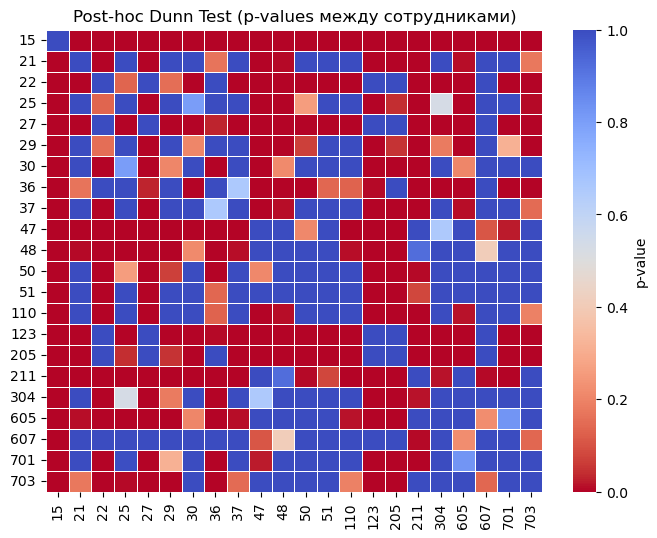

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(posthoc_results, 
            annot=False,      
            cmap="coolwarm_r", 
            cbar_kws={'label': 'p-value'},
            linewidths = .4,
            vmin=0, vmax=1)

plt.title("Post-hoc Dunn Test (p-values между сотрудниками)")
plt.show()

**Бинарная тепловая карта по результатам пост-хок теста Данна: значимые и незначимые различия между сотрудниками (p < 0.05)**

- Красный (p ≥ 0.05) - различия статистически значимы. 
- Зеленый (p < 0.05) - статистически значимых различий нет.   

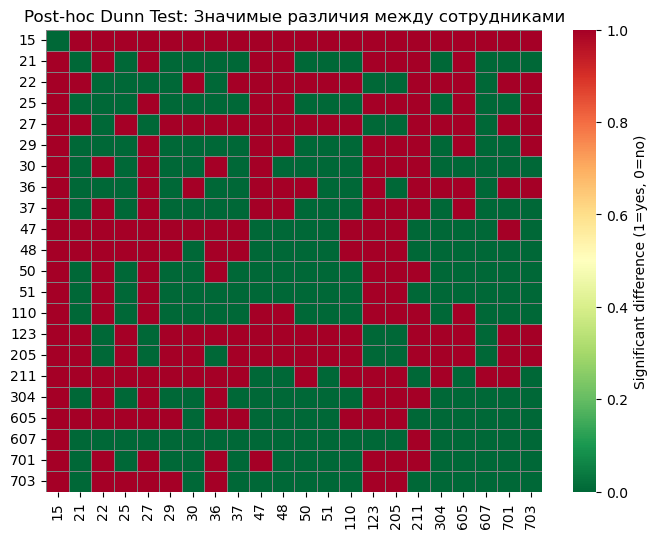

In [12]:
# Превратим p-value в бинарные значения
alpha = 0.05
significance_matrix = (posthoc_results < alpha).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(significance_matrix, 
            cmap="RdYlGn_r",   # красный/зеленый
            annot=False, 
            cbar_kws={'label': 'Significant difference (1=yes, 0=no)'},
            linewidths=0.5, linecolor="gray")

plt.title("Post-hoc Dunn Test: Значимые различия между сотрудниками")
plt.show()

**Выявление сотрудников с отклоняющимся поведением на основе пост-хок анализа**

Выделим "аномальных" сотрудников, которые статистически сильно отличаются почти от всех остальных.   
Их средний чек существенно отличается от большинства других.     
Пороговое значение threshold = 0.8   

In [13]:
alpha = 0.05

# Преобразуем в бинарную: 1 = значимые различия, 0 = нет
binary_matrix = (posthoc_results < alpha).astype(int)

# Посчитаем долю значимых сравнений по каждому сотруднику
significance_ratio = binary_matrix.sum(axis=1) / (binary_matrix.shape[1] - 1)

# Задаем порог (например, 80%)
threshold = 0.8
anomalous_employees = significance_ratio[significance_ratio > threshold]

print("Аномальные сотрудники:")
print(anomalous_employees)

Аномальные сотрудники:
15     1.000000
27     0.809524
123    0.809524
dtype: float64


**Визуализация распределения сотрудников по доле значимых сравнений**

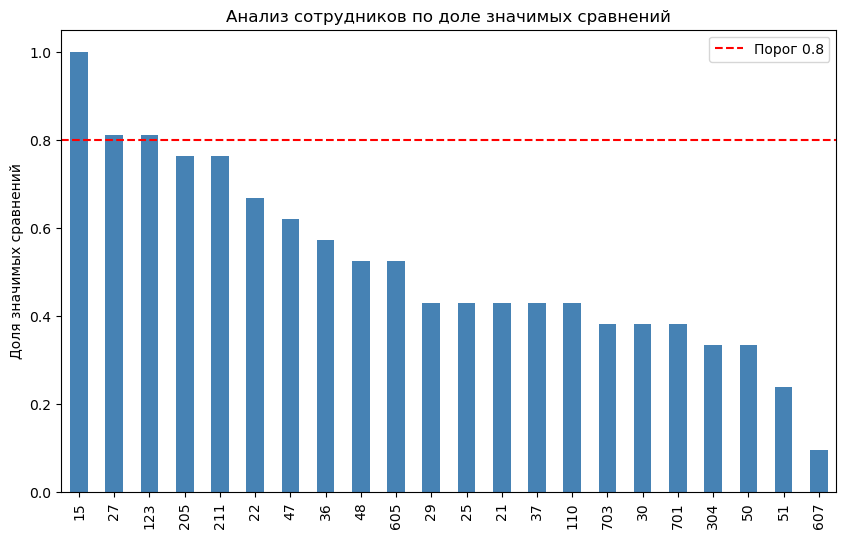

In [14]:
alpha = 0.05

# с: значимые различия (1) / нет (0)
binary_matrix = (posthoc_results < alpha).astype(int)

# Доля значимых сравнений для каждого сотрудника
significance_ratio = binary_matrix.sum(axis=1) / (binary_matrix.shape[1] - 1)

# Сортируем для удобства
significance_ratio_sorted = significance_ratio.sort_values(ascending=False)

# Построим график
plt.figure(figsize=(10,6))
significance_ratio_sorted.plot(kind="bar", color="steelblue")
plt.axhline(0.8, color="red", linestyle="--", label="Порог 0.8")
plt.ylabel("Доля значимых сравнений")
plt.title("Анализ сотрудников по доле значимых сравнений")
plt.legend()
plt.show()

**Локализация аномалий: связываем сотрудников с аптеками**

Аномальные сотрудники и их аптеки:
       dr_tabempl  dr_apt
0              15      11
3186           27       2
3923           27       6
15781         123       2

Средний чек по аптекам:
dr_apt
7     442.025492
18    454.404908
15    529.297178
11    545.692814
13    589.540703
17    591.801682
6     759.509926
2     794.704841
Name: final_price, dtype: float64


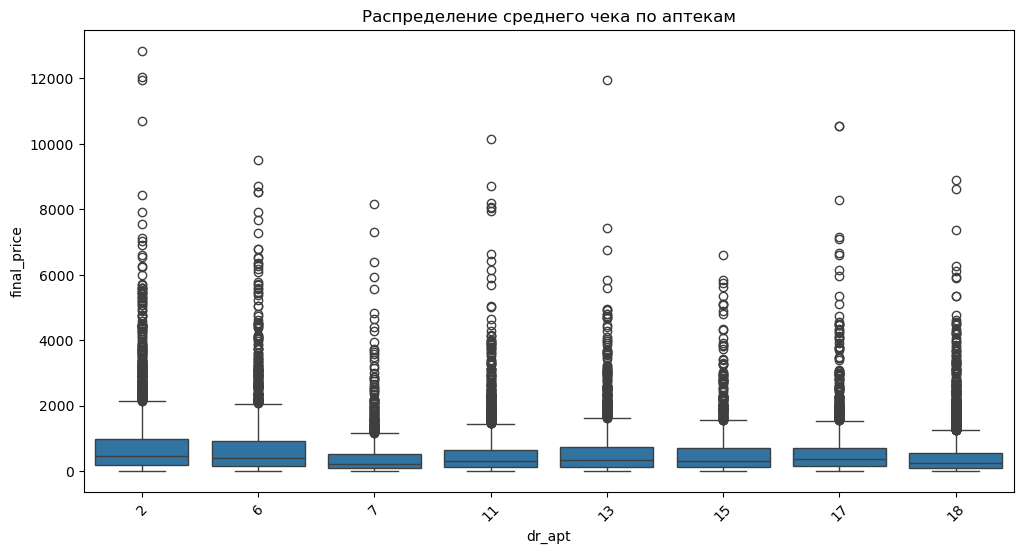

In [15]:
# Проверим, где работают аномальные сотрудники
anom_emps = significance_ratio[significance_ratio > 0.8].index
anom_data = grouped[grouped["dr_tabempl"].isin(anom_emps)]

print("Аномальные сотрудники и их аптеки:")
print(anom_data[["dr_tabempl", "dr_apt"]].drop_duplicates())

# Средний чек по аптекам
avg_by_apt = grouped.groupby("dr_apt")["final_price"].mean().sort_values()
print("\nСредний чек по аптекам:")
print(avg_by_apt)

# Визуализация
plt.figure(figsize=(12,6))
sns.boxplot(x="dr_apt", y="final_price", data=grouped)
plt.xticks(rotation=45)
plt.title("Распределение среднего чека по аптекам")
plt.show()

Результаты анализа гипотезы "Аптеки и выручка" (см. список гипотез) показали статистически значимые различия в среднем чеке между аптеками (p < 0.05), однако сила эффекта низкая (η² ≈ 0.03), что указывает на слабое влияние аптеки на показатель. Несмотря на наличие различий, аптека объясняет лишь незначительную часть вариации. Следовательно, при дальнейшем анализе других факторов (например, влияния сотрудников), переменную "аптека" необходимо учитывать в качестве контролируемого фактора.

**Оценка вклада факторов с помощью ANOVA типа II**

Для корректной оценки влияния сотрудников необходимо учитывать фактор аптеки, чтобы избежать смешения эффектов и корректно выделить вклад каждого источника вариации.

In [16]:
# Многофакторная линейная модель
model = smf.ols('final_price ~ C(dr_tabempl) + C(dr_apt)', data=grouped).fit()

# Таблица ANOVA по типу II (каждый фактор оценивается с учётом другого)
anova_results = sm.stats.anova_lm(model, typ=2)
anova_results

,sum_sq,df,F,PR(>F)
C(dr_tabempl),7.388642e+07,21.0,5.411555,1.149361e-14
C(dr_apt),5.187577e+07,7.0,11.398384,1.626058e-14
Residual,1.362290e+10,20953.0,NaN,NaN


**Интерпретация**
- PR(>F) показывает, что оба фактора и сотрудники (dr_tabempl) и аптеки (dr_apt) статистически значимы (p ≪ 0.05).
- Аптека (dr_apt) объясняет примерно такую же долю дисперсии, как и сотрудник (dr_tabempl).*   
Значит, нельзя рассматривать эффект сотрудника отдельно от аптеки.   
Однако, размер суммы квадратов (sum_sq) по сравнению с остаточной дисперсией (средняя дисперсия, не объяснённая факторами модели) указывает на то, что вклад обоих факторов в общую вариацию относительно небольшой.*

*Примечания  
1. Сравнение вкладов факторов по сумме квадратов (sum_sq):  
- Для сотрудников (dr_tabempl): sum_sq = 4.41×10⁹  
- Для аптек (dr_apt): sum_sq = 4.54×10⁹  
Эти значения одного порядка (разница менее 3%), что показывает, что оба фактора объясняют сопоставимое количество дисперсии в ранговых значениях среднего чека (final_price).

2. Остаточная дисперсия (MSE) рассчитывается из полученных в anova_results данных как отношение Residual к df. Она показывает, насколько хорошо модель в целом объясняет данные — чем меньше остаточная дисперсия, тем лучше подгонка.

**Результаты** 

Анализ показал, что средний чек статистически значимо зависит как от личности сотрудника, так и от аптеки, в которой он работает.
Поскольку большинство сотрудников закреплены только за одной аптекой, взаимодействие между факторами оценить невозможно — эффекты сотрудника и аптеки частично неразделимы.
Следовательно, при анализе индивидуальных различий сотрудников необходимо контролировать влияние аптеки (например, с помощью многоуровневых моделей или поправки на средний чек точки продаж).

1. Средний чек по аптекам   

Низкий средний чек: аптеки 7, 18, 15 (≈ 440–530).   
Средний уровень: аптеки 11, 13, 17 (≈ 545–590).  
Высокий чек: аптеки 6, 2 (≈ 760–790).  
Разрыв между «дешёвыми» и «дорогими» аптеками превышает 70%, что указывает на существенную неоднородность.

2. Аномальные сотрудники   
Выявлены сотрудники, чьи продажи значимо отличаются от коллег в их аптеках:   
- Сотрудник 15 в аптеке 11
- Сотрудник 27 в аптеках 2 и 6
- Сотрудник 123 в аптеке 2
    
Это может быть связано:   
- с успешными техниками продаж (upsell/cross-sell),   
- с риском несоблюдения стандартов (навязывание дорогих товаров).  
- с различным уровнем среднего чека аптек  

**Значение для бизнеса**    
1. Неоднородность аптек     
- Клиентские сегменты и ассортимент значительно различаются.  
- Аптеки 2 и 6 работают в «премиум»-сегменте, аптеки 7 и 18 — в «эконом».  

2. Кластеры аптек   
- Эконом (средний чек < 500)  
- Средний сегмент (500–600)  
- Премиум (> 750)

3. Аномалии сотрудников   
- Сотрудники могут быть «звёздами продаж» (позитивный сценарий).  
- Или создавать риски (жалобы клиентов, потеря лояльности).  

**Рекомендации**
- Сегментировать аптеки по уровням среднего чека, установить разные KPI и стандарты для «эконом», «средних» и «премиум».
- Провести аудит аномальных сотрудников (структура чека, возвраты, жалобы).
- Лучшие практики продаж: если высокие чеки достигнуты корректными методами — использовать их для обучения остальных.
- Контроль рисков: ввести правила прозрачности рекомендаций и стандарты по ассортименту.
- Фокус на баланс: для «эконом»-аптек искать возможности повышения среднего чека (персонализированные рекомендации, допродажи). 

Итог:  
Анализ показал существенную неоднородность аптек и выявил сотрудников-аномалий. Это даёт возможность:
- либо масштабировать лучшие практики,
- либо вовремя выявить и скорректировать риски.